<a href="https://colab.research.google.com/github/morgan03153/game/blob/master/morgan_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas_datareader

In [ ]:
!pip install yfinance pandas numpy scikit-learn keras google-auth google-auth-oauthlib google-auth-httplib2 google-api-python-client google-cloud-storage


訓練程式：調整讓隱藏層神經元增加，並降低drop out比例後，始可以看到準確度提高!

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
<ipython-input-16-7d71e2981ad8>:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nvda_data = nvda_data.fillna(method='ffill').fillna(method='bfill')
<ipython-input-16-7d71e2981ad8>:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vix_data = vix_data.fillna(method='ffill').fillna(method='bfill')
<ipython-input-16-7d71e2981ad8>:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  voo_data = voo_data.fillna(method='ffill').fillna(method='bfill')
<ipython-input-16-7d71e2981ad8>:39: FutureWarning: DataFrame.fillna wi

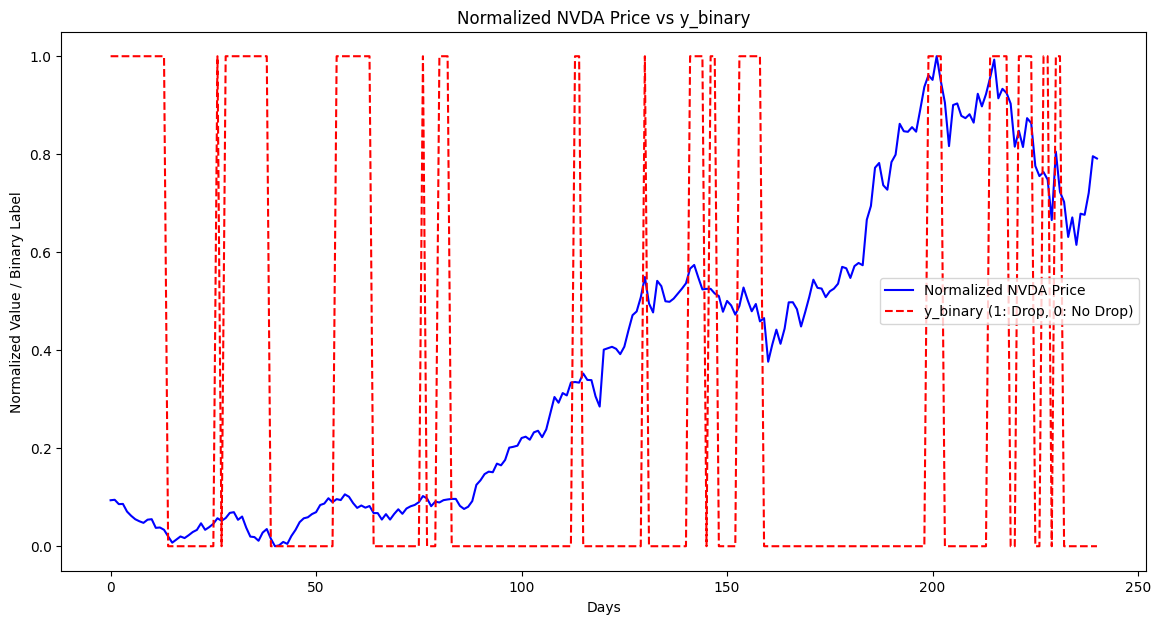

X shape: (191, 50, 4)
y shape: (191,)
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 494ms/step - accuracy: 0.5113 - loss: 0.6667 - val_accuracy: 0.9000 - val_loss: 0.3457
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 304ms/step - accuracy: 0.7468 - loss: 0.6014 - val_accuracy: 0.9000 - val_loss: 0.3589
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.7634 - loss: 0.5513 - val_accuracy: 0.9000 - val_loss: 0.3781
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.7481 - loss: 0.5703 - val_accuracy: 0.9000 - val_loss: 0.4237
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.7474 - loss: 0.5626 - val_accuracy: 0.9000 - val_loss: 0.3868
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.7388 - loss: 0.5645 - val_accuracy: 0.9000 - val_loss: 0.3933
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.7554 - loss: 0.5447 - val_accuracy: 0.9000 - val_loss: 0.4848
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.7641 - loss: 0.5318 - val_accuracy: 0.9000 - val_loss: 0.4391
Epo

Model saved to: /content/drive/My Drive/nvda_lstm/nvda_lstm_model.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7613 - loss: 0.4970
Training Loss: 0.49599260091781616
Training Accuracy: 0.7748690843582153


In [16]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os
import matplotlib.pyplot as plt
from google.colab import drive
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout

# 连接Google Drive
drive.mount('/content/drive')

# 設定保存模型的路徑
save_path = '/content/drive/My Drive/nvda_lstm/'

# 可調整的變數
data_days = 350        # 用于提取数据的天数
look_back = 50         # LSTM 模型的 look back 时间窗口
forward_days = 5       # 設定未来天数范围
drop_threshold = 0.95  # 設定价格下跌比例的閾值

# 設定時間範圍
end_date = datetime.today() - timedelta(days=0)
start_date = end_date - timedelta(days=data_days)

# 獲取各個股票和指數的數據
nvda_data = yf.download('NVDA', start=start_date, end=end_date)
vix_data = yf.download('^VIX', start=start_date, end=end_date)
voo_data = yf.download('VOO', start=start_date, end=end_date)
msft_data = yf.download('MSFT', start=start_date, end=end_date)
tsm_data = yf.download('TSM', start=start_date, end=end_date)

# 填充缺失值
nvda_data = nvda_data.fillna(method='ffill').fillna(method='bfill')
vix_data = vix_data.fillna(method='ffill').fillna(method='bfill')
voo_data = voo_data.fillna(method='ffill').fillna(method='bfill')
msft_data = msft_data.fillna(method='ffill').fillna(method='bfill')
tsm_data = tsm_data.fillna(method='ffill').fillna(method='bfill')

# 对齐所有数据的索引
combined_data = pd.concat([nvda_data['Close'], vix_data['Close'], voo_data['Close'], msft_data['Close']], axis=1).dropna()
combined_data.columns = ['NVDA', 'VIX', 'VOO', 'MSFT']

# 对每个特征单独进行标准化
scalers = {}
for column in combined_data.columns:
    scaler = MinMaxScaler(feature_range=(0, 1))
    combined_data[column] = scaler.fit_transform(combined_data[[column]])
    scalers[column] = scaler

# 創建 y_binary 值，判断未來指定天數內是否曾經跌破當日股價的指定比例
def create_y_binary(nvda_scaled, forward_days, drop_threshold):
    y_binary = np.zeros_like(nvda_scaled)
    for i in range(len(nvda_scaled) - forward_days):
        current_price = nvda_scaled[i]
        future_prices = nvda_scaled[i+forward_days]
        if future_prices < current_price * drop_threshold:
            y_binary[i] = 1
    return y_binary

# 創建 y_binary 和 nvda_scaled 曲線圖
nvda_scaled = combined_data['NVDA'].values  # 取 NVDA 数据的缩放结果
y_binary = create_y_binary(nvda_scaled, forward_days, drop_threshold)

plt.figure(figsize=(14, 7))
plt.plot(nvda_scaled, color='blue', label='Normalized NVDA Price')
plt.plot(y_binary, color='red', linestyle='--', label='y_binary (1: Drop, 0: No Drop)')
plt.title('Normalized NVDA Price vs y_binary')
plt.xlabel('Days')
plt.ylabel('Normalized Value / Binary Label')
plt.legend()
plt.show()

# 創建數據集
def create_dataset(X, y, look_back):
    Xs, ys = [], []
    for i in range(len(X) - look_back):
        Xs.append(X[i:i + look_back])
        ys.append(y[i + look_back])
    return np.array(Xs), np.array(ys)

# 創建 X 和 y 數據集
X, y = create_dataset(combined_data.values, y_binary, look_back)

# 確認 X 的形狀
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# 確保 X 是三維的
if len(X.shape) != 3:
    raise ValueError("X does not have the correct shape. Expected a 3D array.")

# 構建 LSTM 模型
model = Sequential()
model.add(LSTM(units=200, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(units=1, activation='sigmoid'))  # 二元分類使用 sigmoid 激活函數
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 訓練模型
model.fit(X, y, epochs=20, batch_size=50, validation_split=0.05, verbose=1)

# 保存模型
model_save_path = os.path.join(save_path, 'nvda_lstm_model.h5')
model.save(model_save_path)
print(f'Model saved to: {model_save_path}')

# 模型評估
loss, accuracy = model.evaluate(X, y)
print(f'Training Loss: {loss}')
print(f'Training Accuracy: {accuracy}')

# 創建檢查內層輸出值的模型
#intermediate_layer_model = Model(inputs=model.input,
#                                 outputs=model.layers[0].output)  # 输出第一个LSTM层的结果

# 測試內層輸出值
#intermediate_output = intermediate_layer_model.predict(X)
#print("Intermediate output shape:", intermediate_output.shape)
#print("Sample intermediate output for first sequence:", intermediate_output[0])

推論程式

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
<ipython-input-17-1a865ae66659>:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nvda_data = nvda_data.fillna(method='ffill').fillna(method='bfill')
<ipython-input-17-1a865ae66659>:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vix_data = vix_data.fillna(method='ffill').fillna(method='bfill')
<ipython-input-17-1a865ae66659>:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  voo_data = voo_data.fillna(method='ffill').fillna(method='bfill')
<ipython-input-17-1a865ae66659>:38: FutureWarning: DataFrame.fillna wi

X shape: (191, 50, 4)
y shape: (191,)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━

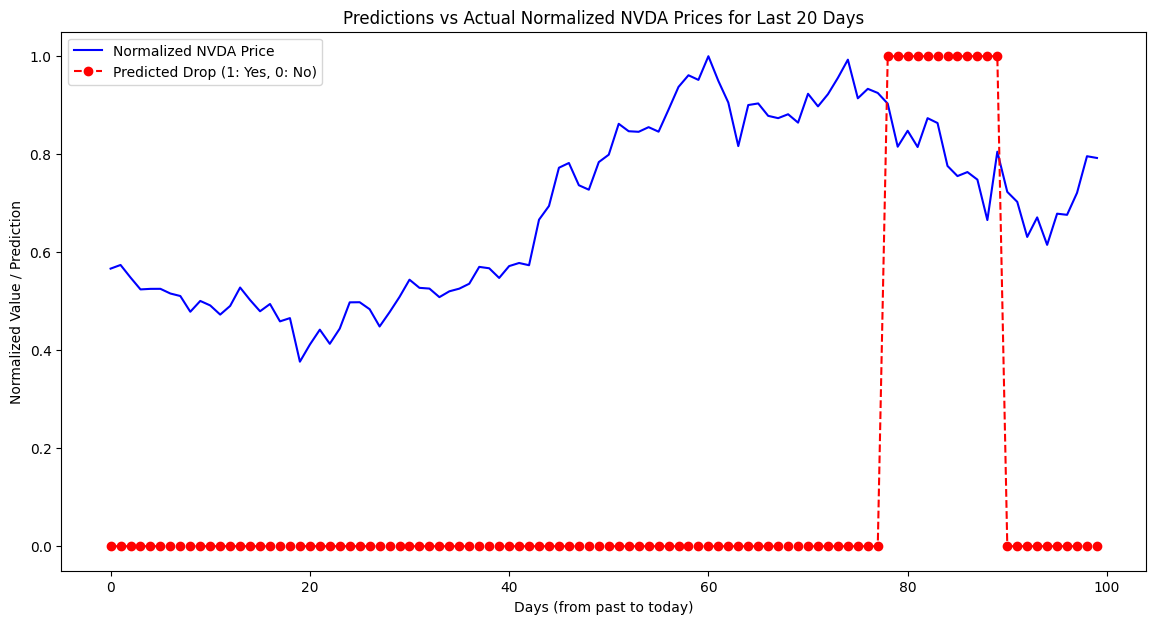

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Today's Prediction (Binary): 0


In [17]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os
import matplotlib.pyplot as plt
from google.colab import drive
from keras.models import load_model

# 连接Google Drive
drive.mount('/content/drive')

# 設定保存模型的路徑
save_path = '/content/drive/My Drive/nvda_lstm/'

# 可調整的變數
data_days = 350        # 用于提取数据的天数
look_back = 50         # LSTM 模型的 look back 时间窗口
forward_days = 5       # 設定未来天数范围
drop_threshold = 0.95  # 設定价格下跌比例的閾值

# 設定時間範圍
end_date = datetime.today() - timedelta(days=0)
start_date = end_date - timedelta(days=data_days)

# 獲取各個股票和指數的數據
nvda_data = yf.download('NVDA', start=start_date, end=end_date)
vix_data = yf.download('^VIX', start=start_date, end=end_date)
voo_data = yf.download('VOO', start=start_date, end=end_date)
msft_data = yf.download('MSFT', start=start_date, end=end_date)
tsm_data = yf.download('TSM', start=start_date, end=end_date)

# 填充缺失值
nvda_data = nvda_data.fillna(method='ffill').fillna(method='bfill')
vix_data = vix_data.fillna(method='ffill').fillna(method='bfill')
voo_data = voo_data.fillna(method='ffill').fillna(method='bfill')
msft_data = msft_data.fillna(method='ffill').fillna(method='bfill')
tsm_data = tsm_data.fillna(method='ffill').fillna(method='bfill')

# 对齐所有数据的索引
combined_data = pd.concat([nvda_data['Close'], vix_data['Close'], voo_data['Close'], msft_data['Close']], axis=1).dropna()
combined_data.columns = ['NVDA', 'VIX', 'VOO', 'MSFT']

# 对每个特征单独进行标准化
scalers = {}
for column in combined_data.columns:
    scaler = MinMaxScaler(feature_range=(0, 1))
    combined_data[column] = scaler.fit_transform(combined_data[[column]])
    scalers[column] = scaler

# 創建 y_binary 值，判断未來指定天數內是否曾經跌破當日股價的指定比例
def create_y_binary(nvda_scaled, forward_days, drop_threshold):
    y_binary = np.zeros_like(nvda_scaled)
    for i in range(len(nvda_scaled) - forward_days):
        current_price = nvda_scaled[i]
        future_prices = np.mean(nvda_scaled[i+1:i+forward_days])
        if future_prices < current_price * drop_threshold:
            y_binary[i] = 1
    return y_binary

# 創建數據集
nvda_scaled = combined_data['NVDA'].values
y_binary = create_y_binary(nvda_scaled, forward_days, drop_threshold)

def create_dataset(X, y, look_back):
    Xs, ys = [], []
    for i in range(len(X) - look_back):
        Xs.append(X[i:i + look_back])
        ys.append(y[i + look_back])
    return np.array(Xs), np.array(ys)

# 創建 X 和 y 數據集
X, y = create_dataset(combined_data.values, y_binary, look_back)

# 確認 X 的形狀
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# 確保 X 是三維的
if len(X.shape) != 3:
    raise ValueError("X does not have the correct shape. Expected a 3D array.")

# 加载模型
model = load_model(os.path.join(save_path, 'nvda_lstm_model.h5'))

# 保存過去20天的預測結果
predictions_binary = []
actual_prices = []

for i in range(100):
    # 从最近的历史数据中提取X进行预测
    X_input = X[-(i + 1)].reshape(1, X.shape[1], X.shape[2])
    y_pred = model.predict(X_input)
    y_pred_binary = (y_pred > 0.5).astype(int)
    predictions_binary.append(y_pred_binary[0][0])

    # 保存相应的实际价格
    actual_prices.append(nvda_scaled[-(i + 1)])

# 逆序，使日期從過去到現在
predictions_binary.reverse()
actual_prices.reverse()

# 繪製實際價格（正規化後）和預測結果
plt.figure(figsize=(14, 7))
plt.plot(range(100), actual_prices, color='blue', label='Normalized NVDA Price')
plt.plot(range(100), predictions_binary, color='red', linestyle='--', marker='o', label='Predicted Drop (1: Yes, 0: No)')
plt.title('Predictions vs Actual Normalized NVDA Prices for Last 20 Days')
plt.xlabel('Days (from past to today)')
plt.ylabel('Normalized Value / Prediction')
plt.legend()
plt.show()

# 推論基於今天的結果
X_today = X[-1].reshape(1, X.shape[1], X.shape[2])
y_pred_today = model.predict(X_today)
y_pred_today_binary = (y_pred_today > 0.5).astype(int)

# 顯示今天的推論結果
print(f"Today's Prediction (Binary): {y_pred_today_binary[0][0]}")